<a href="https://colab.research.google.com/github/mahesh-keswani/ML-DL-Basics/blob/main/keras_examples/GuidedBackprop_AND_GuidedGradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Source: https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
# GuidedBackprop: https://www.youtube.com/watch?v=rcXOEzAuvu4&list=PLyqSpQzTE6M9gCgajvQbc68Hk_JKGBAYT&index=98
# GradCAM and Guided GradCAM: https://www.youtube.com/watch?v=VmbBnSv3otc

import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
#Setting the image path and the last conv layer for VGG19
IMAGE_PATH = './cat_and_dog.png'
LAYER_NAME='block5_conv4'

In [3]:
#Load the image
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))

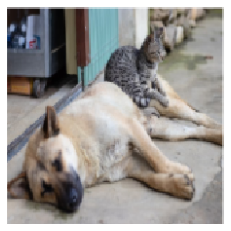

In [4]:
# Displaying the original image
plt.axis("off")
plt.imshow(img);

In [5]:
# Preprocess the image using vgg19 preprocess function
img =  tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(img, axis=0)
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(x)

In [6]:
#Create the transfer learned model
model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=True)

In [7]:
# We create a model from the VGG19 until the last convolutional layer, therefore output is conv layer (output_shape=14x14x512)
gb_model = tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer(LAYER_NAME).output]
)

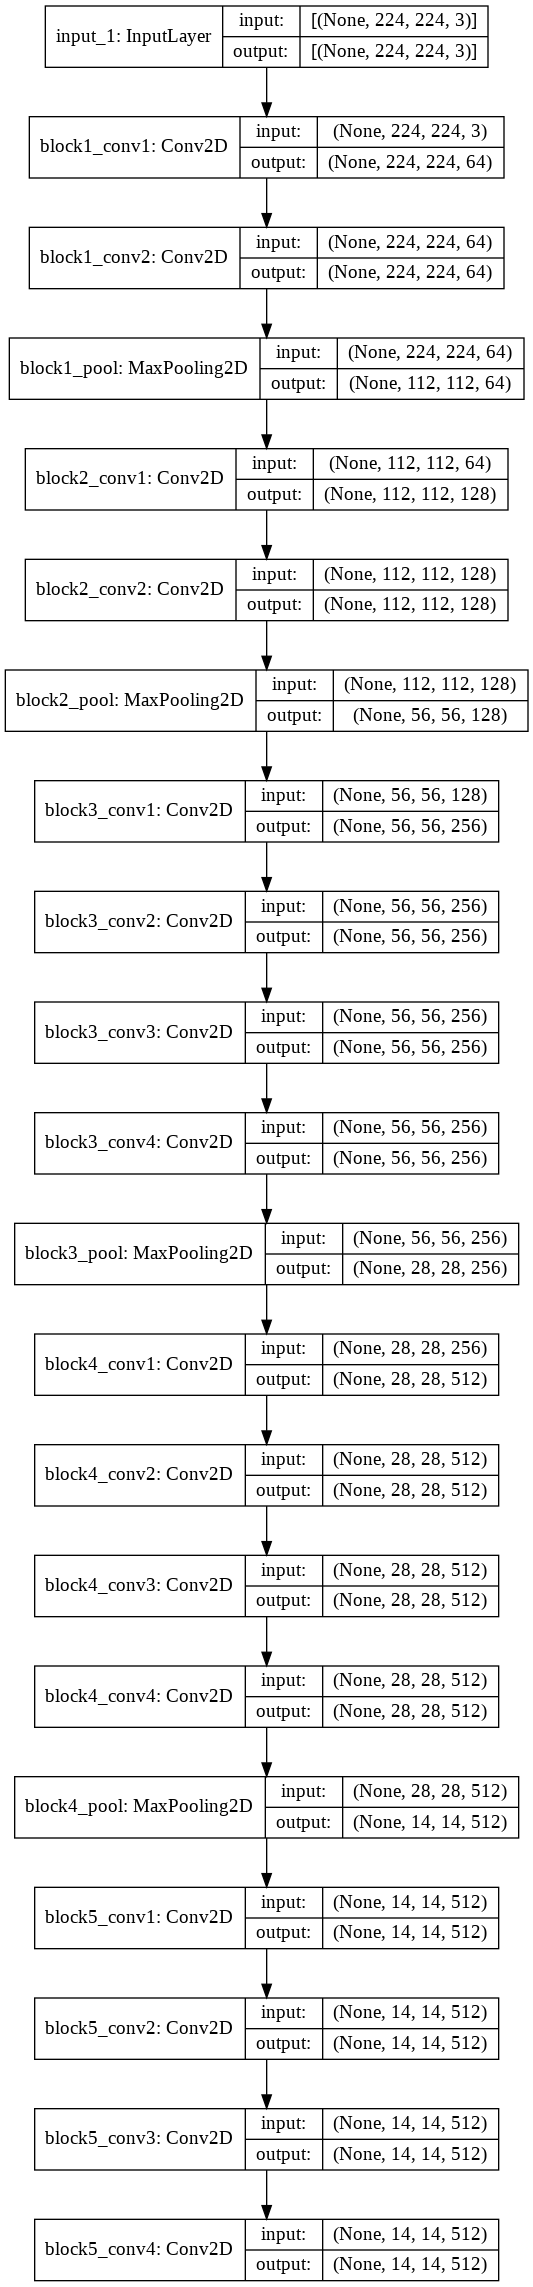

In [8]:
from tensorflow.keras.utils import plot_model

# plot model architecture
plot_model(gb_model, show_shapes=True, to_file='vgg19.png')

In [9]:
# getting all conv layers
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
    print(layer.name)

block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block5_conv1
block5_conv2
block5_conv3
block5_conv4


In [10]:
# EXAMPLE OF @tf.custom_gradient
# Source: https://stackoverflow.com/questions/43839431/tensorflow-how-to-replace-or-modify-gradient

# @tf.custom_gradient
# def func(x):
#     f = # calculate forward pass
#     def grad(dy):
#         gradient = # calculate custom gradient of func
#         return dy * gradient
#     return f, grad

In [11]:
# 5.2 > 0 will return true (i.e 1.0), then cast is used to convert it into float32
tf.cast( 5.2 > 0, dtype='float32' )

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [12]:
# Gradients of ReLU can be overridden by applying "@tf.custom_gradient" which allows fine-grained control 
# over the gradients for backpropagating non-negative gradients to have a more efficient or 
# numerically stable gradient.
# During forwarc pass it will forward it as max(x, 0) and during backprop, it will be max(0, grad)

# 
# @tf.custom_gradient
# def guidedRelu(x):
#   def grad(dy):
#     return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
#   return tf.nn.relu(x), grad

# in the source: the gradient is return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
# I was not sure was there is x, therefore I did experiment without it.

@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * dy

  return tf.nn.relu(x), grad

In [13]:
# Apply guided ReLU to all the Conv layers where activation was ReLU

for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu

In [14]:
# Use Gradient Tape to watch the preprocessed input image for the forward pass which will 
# help calculate the gradients for the backward pass. Use the GradientTape object to capture 
# the gradients on the last Conv layer.

# Here we find the gradients of the target class score with respect to the feature maps 
# of the last convolutional layer

# watch example: https://www.geeksforgeeks.org/python-tensorflow-gradienttape-watch/

with tf.GradientTape() as tape:
    # converting image to float32
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)

    # taking the prediction for the first image (since it was batch)
    outputs = gb_model(inputs)[0]
    print(outputs)

    # finding the gradient of tensor with shape (14, 14, 512) w.r.t input image with shape (224, 224, 3)
    grads = tape.gradient(outputs,inputs)[0]
    print(grads.shape)

tf.Tensor(
[[[ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  ...
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]]

 [[ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  ...
  [ 0.         0.         0.        ...  0.         0.         4.5853877]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]]

 [[ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.     

In [15]:
print(grads.shape)

(224, 224, 3)


In [16]:
# printing first five values for every channel
print(grads[:5, 0, 0])
print(grads[:5, 0, 1])
print(grads[:5, 0, 2])

tf.Tensor([ 3.3348045  4.3019023 14.452814  -5.993542   0.3133235], shape=(5,), dtype=float32)
tf.Tensor([  6.9208746   8.931691   12.570053  -19.21423   -20.83013  ], shape=(5,), dtype=float32)
tf.Tensor([  5.83623     7.3641667  13.073228  -14.070343  -10.257408 ], shape=(5,), dtype=float32)


In [17]:
# printing mean of first channel
print( np.mean( grads[:, :, 0] ) )

# printing mean of second channel
print( np.mean( grads[:, :, 1] ) )

# printing mean of third channel
print( np.mean( grads[:, :, 2] ) )


-0.15706941
-13.904603
8.88204


In [18]:
# Grad Classification Activation Map(Grad CAM)

# Average the gradients spatially where each entry is the mean intensity of the gradient 
# over a specific feature map channel. Build a ponderated map of filters according to gradient 
# importance. The result is the final class discriminative saliency map.

# This is basically taking mean of all the values in every channel 
weights = tf.reduce_mean(grads, axis=(0, 1))
print( weights )

tf.Tensor([ -0.15706967 -13.904591     8.882153  ], shape=(3,), dtype=float32)


In [19]:
# Output shape is (14, 14, 512)
# Here we are just taking 101, 102, 103 channels out of 512 channels, and then multiplying them with weights
# Ideally you should take all the channels and take the weighted sum of them.
# You can take any three channels you want out of 512

grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
for channel, w in enumerate(weights):
    # grad_cam = w1*first_channel + w2*second_channel + w3*third_channel  
    grad_cam += w * outputs[:, :, channel + 100]

In [20]:
# Divide each intensity value of the heatmap with the maximum intensity value
# to normalize the heatmap such that all values fall between 0 and 1 and plot the 
# Gradient Class Activation map on the image

grad_cam_img = cv2.resize(grad_cam.numpy(), (224, 224))
grad_cam_img = np.maximum(grad_cam_img, 0)

heatmap = (grad_cam_img - grad_cam_img.min()) / (grad_cam_img.max() - grad_cam_img.min())
#                                converting into RGB
grad_cam_img = cv2.applyColorMap( np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor( img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, grad_cam_img, 1, 0)


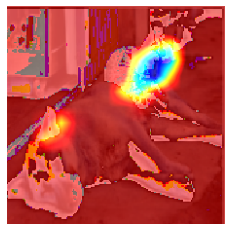

In [21]:
plt.imshow(output_image)
plt.axis("off");

In [22]:
# Guided BackPropagation

# More on np.dstack() https://www.geeksforgeeks.org/python-numpy-dstack-method/

#Visualizing the guided back prop, remember: grads is (224, 224, 3)
gb_viz = grads.numpy()

In [23]:
gb_viz.shape

(224, 224, 3)

In [24]:
# Normalizing it
# gb_viz = (gb_viz - min) / max

gb_viz -= np.min(gb_viz)
gb_viz /= gb_viz.max()

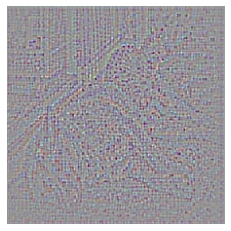

In [25]:
imgplot = plt.imshow(gb_viz)
plt.axis("off");

In [26]:
# Guided Gradient Class Activation Map(Guided Grad CAM)

# Guided Grad CAM combines the best aspects of Grad CAM and Guided Backpropagation via 
# element-wise multiplication. The visualization for Guided Grad CAM is both high-resolution 
# and class-discriminative

In [27]:
# Remember: grad_cam is (14, 14)
guided_cam = np.maximum(grad_cam, 0)
guided_cam = guided_cam / np.max(guided_cam) # scale 0 to 1.0
guided_cam = resize(guided_cam, (224,224), preserve_range=True)

In [28]:
guided_back_prop = grads.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


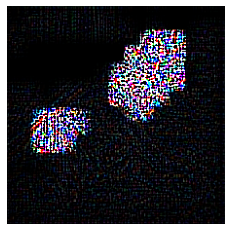

In [29]:
#pointwise multiplcation of guided backprop and grad CAM 
# guided_cam is (224, 224) and then multiplying it with every channel of grads 
gd_gb = np.dstack((
        guided_back_prop[:, :, 0] * guided_cam, # (224, 224) * (224, 224)
        guided_back_prop[:, :, 1] * guided_cam,
        guided_back_prop[:, :, 2] * guided_cam,
    ))

imgplot = plt.imshow(gd_gb)
plt.axis("off");

In [30]:
# The visualization highlights the pixels for the ears, the nose, the body of the dog, 
# and its paws that the model looks to make the prediction for the dog and the cat 
# features are not highlighted.